# QP constrained optimization: Normalizing Flow with moment constraints

* Objective: maximize absolute entropy.
* Constraint: $\Sigma = \langle xx^T \rangle = I$.

In [1]:
import math
from typing import Callable

import torch
import matplotlib.pyplot as plt
from tqdm.notebook import trange

import zuko

In [2]:
class FlowDist(torch.nn.Module):
    def __init__(
        self,
        ndim: int,
        transforms: int = 3,
        hidden_layers: int = 3,
        hidden_units: int = 64,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        self.flow = zuko.flows.NSF(
            features=ndim,
            transforms=transforms,
            hidden_features=(hidden_layers * [hidden_units]),
        )
        # Reverse for faster sampling
        self.flow = zuko.flows.Flow(self.flow.transform.inv, self.flow.base)

    def sample(self, n: int) -> torch.Tensor:
        return self.flow().rsample((n,))

    def log_prob(self, z: torch.Tensor) -> torch.Tensor:
        return self.flow().log_prob(z)

    def sample_and_log_prob(self, n: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.flow().rsample_and_log_prob((n,))
    
    def entropy(self, n: int, prior=None) -> torch.Tensor:
        x, log_p = self.sample_and_log_prob(n)
        if prior is None:
            log_q = torch.zeros(log_p.shape)
        else:
            log_q = prior.log_prob(x)
        return -torch.mean(log_p - log_q)
        

In [3]:
class QPOptimizer:
    def __init__(
        self, 
        distribution: FlowDist,
        optimizer: torch.optim.Optimizer, 
        constraint_function: Callable,
        c: float= 1.0,
        eps: float = 1.00e-12,
        batch_size: int = 10_000,
    ) -> None:
        self.distribution = distribution
        self.optimizer = optimizer
        self.constraint_function = constraint_function
        self.c = c
        self.eps = eps
        self.batch_size = batch_size        

    def step(self) -> dict:
        self.optimizer.zero_grad()

        # Sample particles coordinates and density at each point
        x, log_prob = self.distribution.sample_and_log_prob(self.batch_size)

        # Compute objective function gradient
        f = torch.mean(log_prob)
        f.backward(retain_graph=True)

        grads_f = []
        for p in self.distribution.parameters():
            if p.grad is not None:
                grads_f.append(p.grad.clone())

        for p in self.distribution.parameters():
            p.grad.zero_()

        # Compute constraint function gradient
        g = self.constraint_function(x)
        g.backward()

        grads_g = []
        for p in self.distribution.parameters():
            if p.grad is not None:
                grads_g.append(p.grad.clone())

        # Step optimizer with mixed gradient
        with torch.no_grad():
            grad_f_vec = torch.hstack([grad.ravel() for grad in grads_f])
            grad_g_vec = torch.hstack([grad.ravel() for grad in grads_g])
            alpha = max(0.0, -torch.dot(grad_f_vec, grad_g_vec) + self.c * g) / max(torch.linalg.norm(grad_g_vec)**2, self.eps)
            
            for i, p in enumerate(self.distribution.parameters()):
                p.grad = grads_f[i] + alpha * grads_g[i]

            self.optimizer.step()

        output = {}
        output["f"] = f.detach()
        output["g"] = g.detach()
        return output

In [4]:
def constraint_function(x: torch.Tensor) -> torch.Tensor:
    x_avg = torch.mean(x, axis=0)
    x_cov = torch.cov(x.T)

    loss = 0.0
    # loss += torch.mean(torch.square(x_avg - 0.0))
    loss += torch.mean(torch.square(x_cov - torch.eye(x.shape[1])))
    return loss

In [9]:
ndim = 2
c = 1.0

distribution = FlowDist(ndim=ndim)
    
optimizer = torch.optim.Adam(distribution.parameters(), lr=0.005)

qp_optimizer = QPOptimizer(
    distribution=distribution,
    optimizer=optimizer,
    constraint_function=constraint_function,
    c=c,
    batch_size=10_000,
)

for iteration in trange(50):
    optimizer.zero_grad()
    loss = -distribution.entropy(1000)
    loss.backward()
    optimizer.step()

history = {"f": [], "g": []}
for iteration in trange(300):
    output = qp_optimizer.step()

    history["f"].append(output["f"])
    history["g"].append(output["g"])

    if iteration > 100:
        for param_group in optimizer.param_groups:
            param_group["lr"] *= 0.5
            param_group["lr"] = max(param_group["lr"], 0.001)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

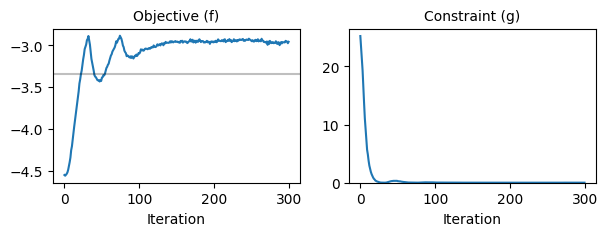

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(7.0, 2.0), sharex=True)
axs[0].plot(history["f"])
axs[1].plot(history["g"])
axs[1].set_ylim(0.0, axs[1].get_ylim()[1])
axs[0].set_title("Objective (f)", fontsize="medium")
axs[1].set_title("Constraint (g)", fontsize="medium")
for ax in axs:
    ax.set_xlabel("Iteration")

entropy_targ = (0.5 * ndim) * (1.0 + math.log(2.0 * math.pi)) + 0.5 * (1.0)
axs[0].axhline(-entropy_targ, color="black", alpha=0.25)
plt.show()

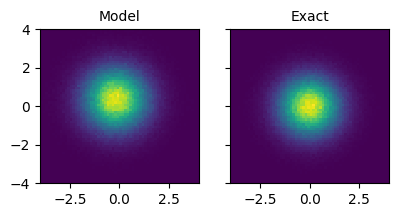

In [11]:
with torch.no_grad():
    x_pred = distribution.sample(500_000)
    x_true = torch.randn(x_pred.shape)
    fig, axs = plt.subplots(figsize=(4.5, 2.0), ncols=2, sharex=True, sharey=True)
    xmax = 4.0
    for x, ax in zip([x_pred, x_true], axs):
        ax.hist2d(x[:, 0], x[:, 1], bins=64, range=[(-xmax, xmax), (-xmax, xmax)])
    axs[0].set_title("Model", fontsize="medium")
    axs[1].set_title("Exact", fontsize="medium")
    plt.show()

In [12]:
print(torch.mean(x, axis=0))
print(torch.cov(x.T) - torch.eye(ndim))

tensor([-0.0008, -0.0007])
tensor([[0.0025, 0.0001],
        [0.0001, 0.0042]])
